In [1]:
%matplotlib notebook

from sdss import SDSS
import mikkel_tools.utility as mt_util
import plot as sds_plt

import numpy as np
#import cupy as cp
import scipy as sp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pyshtools
import pickle

comment = "Investigation into shape of ensemble of semi-variograms."
nb_name = "nb_seqsim_core_sh30_sv_all"

<IPython.core.display.Javascript object>


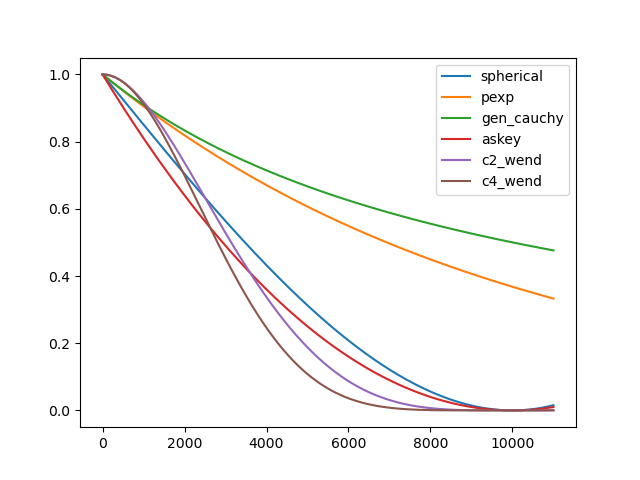

In [24]:
t = np.linspace(0,11000,1000)
c = 10000
a = 1
tau_cauchy = 1
tau_askey = 2
tau_c2 = 4
tau_c4 = 6

spherical = (1+1/2*t/c)*(1-t/c)**2
pexp = np.exp(-(t/c)**a)
gen_cauchy = (1+(t/c))**(-tau_cauchy/a)
askey = (1-t/c)**tau_askey
c2_wend = (1+tau_c2*t/c)*(1-t/c)**tau_c2
c4_wend = (1+tau_c4*t/c+(tau_c4**2-1)/3*t**2/c**2)*(1-t/c)**tau_c4

plt.figure()
plt.plot(t,spherical,t,pexp,t,gen_cauchy,t,askey,t,c2_wend,t,c4_wend)
plt.legend(("spherical", "pexp", "gen_cauchy","askey","c2_wend","c4_wend"))
plt.show()

# Core

In [2]:
shc_g = 30
shc_grid = 30

core = SDSS(comment, N_SH = shc_g, sim_type = "core", sat_height = 350)

core.grid_glq(nmax = shc_grid, r_at = core.r_cmb)

grid_in = np.array([core.grid_phi, 90-core.grid_theta]).T
core.make_grid(core.r_cmb, grid_in, calc_sph_d = True)


In [3]:
core.generate_map(target_var_factor = 1)

In [4]:
g_core_ens = np.genfromtxt("lithosphere_prior/grids/shcoeff_Dynamo/gnm_midpath.dat").T*10**9

In [5]:
core.ensemble_B(g_core_ens, nmax = shc_g, r_at = core.r_cmb, grid_type = "glq")
m_core_ens = core.B_ensemble[:,0,:].copy()[:,200:]

var_core_ens = np.var(m_core_ens,axis=0)

idx_close_to_var = np.argwhere(np.logical_and(var_core_ens>0.9970*np.mean(var_core_ens), var_core_ens<1.0030*np.mean(var_core_ens)))

In [6]:
idx_close_to_var

array([[ 89],
       [139],
       [157],
       [211],
       [221],
       [235],
       [384],
       [405],
       [409],
       [413],
       [417]])

In [7]:
m_core_ens.shape

(1891, 487)

In [8]:
core.semivar(model_lags = "all", model = "exponential", max_dist = 20000, lag_length = 20,
             zero_nugget = True, hit_target_var = True)

keep_sv_curve = core.sv_curve.copy()
keep_lags_sv_curve = core.lags_sv_curve.copy()

C_e_const = 2.0

set_model = {"a": 1700, "C0": 0.0, "C1": core.target_var, "C2": None, "C3": None}

core.semivar(model_lags = "all", model = "exponential", max_dist = 20000, lag_length = 20,
             zero_nugget = True, hit_target_var = True, set_model = set_model)

____semi-variogram setup___

Number of data used: 3575881
Max data distance: 10919.075 km
Lag length chosen: 20.0 km
Number of lags: 545
Number of modelling lags: all

Semi-variogram model determined, starting LUT computation

____semi-variogram setup___

Number of data used: 3575881
Max data distance: 10919.075 km
Lag length chosen: 20.0 km
Number of lags: 545
Number of modelling lags: all

Semi-variogram model determined, starting LUT computation



<IPython.core.display.Javascript object>


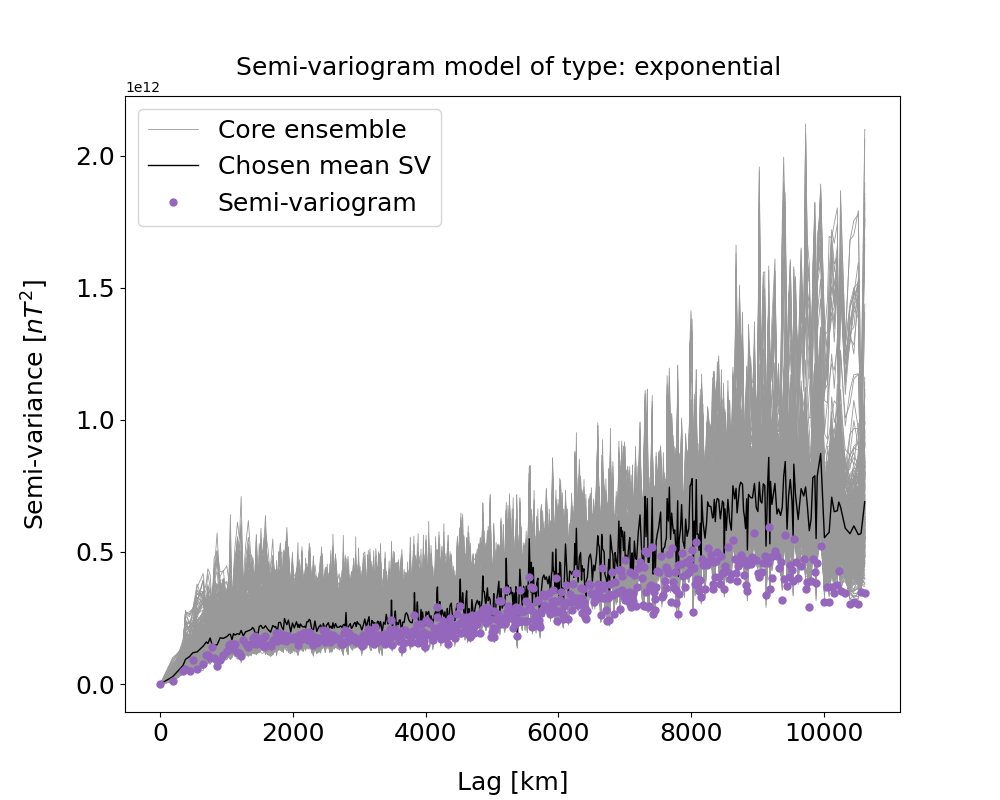

In [49]:
#%% PLOT SEMI-VARIOGRAM
plt.figure(figsize=(10,8)) 

# Ensemble
for i in np.arange(0,m_core_ens.shape[1]):
    core.sv_m_DSS(m_core_ens.shape[0], 1, m_core_ens[:,[i]], core.sort_d, core.n_lags, core.max_cloud)
    if i == 0:
        plt.plot(core.lags, core.pics_m_DSS[:,0], color = (0.6,0.6,0.6), label='Core ensemble', linewidth = 0.6,zorder=0)
    elif i == idx_close_to_var[-1]:
        plt.plot(core.lags, core.pics_m_DSS[:,0], color = "black", label='Chosen mean SV', linewidth = 1.0,zorder=0.1)
    else:
        plt.plot(core.lags, core.pics_m_DSS[:,0], color = (0.6,0.6,0.6), linewidth = 0.6,zorder=0) 

plt.plot(core.lags,core.pics,'o', markersize=5,color = 'C4',label='Semi-variogram')
#plt.plot(core.lags_sv_curve,core.sv_curve,color='C1', linewidth = 1,label='Defined model')
#plt.plot(keep_lags_sv_curve,keep_sv_curve,"--",color='C0',linewidth = 1,label='Fitted model')

#plt.plot(core.lags_sv_curve,np.ones(core.lags_sv_curve.shape)*core.target_var,linewidth = 1,
#         color="C2", linestyle="dashed", label="Training image variance")


#core.sv_m_DSS(len(core.data), 1, core.data.reshape(-1,1), core.sort_d, core.n_lags, core.max_cloud)
#plt.plot(core.lags, core.pics_m_DSS, color = "black", label='Re-data', linewidth = 1.0)

plt.ylabel('Semi-variance $[%s^2]$' % "nT",fontsize=18,labelpad=18)
plt.xlabel('Lag [km]',fontsize=18,labelpad=18)
plt.title("Semi-variogram model of type: %s " % core.model_names[core.model],fontsize=18,y=1.02)
plt.legend(loc='best',fontsize=18)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.show()

In [10]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

a = core.a
c = core.r_cmb
n_max = 30

g_cut = g_core_ens[:n_max*(2+n_max),200:] # Truncate g

R = mt_util.lowe_shspec(n_max,c,a,g_cut)

In [11]:
R.shape

(30, 487)

In [12]:
g_cut_one = g_core_ens[:,0][:n_max*(2+n_max)]
R_one = mt_util.lowe_shspec(n_max,c,a,g_cut_one.reshape(-1,1))

In [13]:
ens_cilm_compare = np.array(pyshtools.shio.SHVectorToCilm(np.hstack((np.zeros(1,), g_cut_one))))

p_spec_compare = pyshtools.gravmag.mag_spectrum(ens_cilm_compare, a, c, degrees = np.arange(1,np.shape(ens_cilm_compare)[1]))

<IPython.core.display.Javascript object>


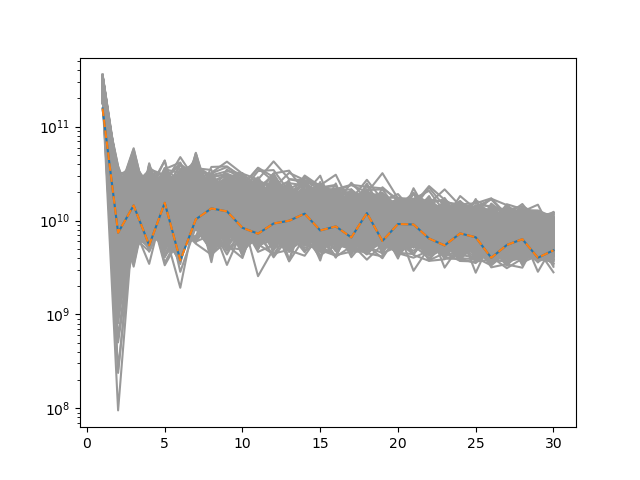

In [15]:
plt.figure()
plt.semilogy(np.arange(1,n_max+1),R,color=(0.6,0.6,0.6))
plt.semilogy(np.arange(1,n_max+1),R_one)
plt.semilogy(np.arange(1,n_max+1),p_spec_compare,linestyle="dashed")
plt.show()

In [16]:
theta_s, theta_d, phi_s, phi_d = map(np.radians, 
                                     [core.grid_theta.reshape(1,-1), core.grid_theta.reshape(-1,1), 
                                      core.grid_phi.reshape(1,-1), core.grid_phi.reshape(-1,1)])

c_angdist = np.cos(theta_d)*np.cos(theta_s)+np.multiply(np.sin(theta_d)@np.sin(theta_s),np.cos(phi_d-phi_s))

c_angdist[c_angdist>1] = 1.0

c_angdist.shape

(1891, 1891)

<IPython.core.display.Javascript object>


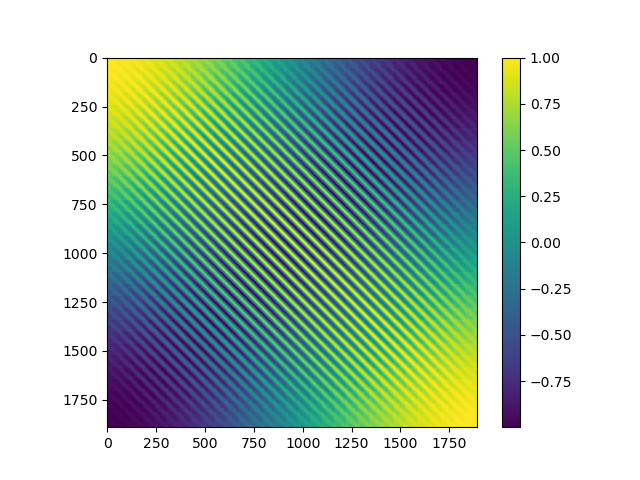

In [17]:
plt.figure()
plt.imshow(c_angdist)
plt.colorbar()
plt.show()

In [18]:
#P = pyshtools.legendre.PlmSchmidt(10,0.3)

P = pyshtools.legendre.PlSchmidt(30,-0.9)[1:]

(30,)


<IPython.core.display.Javascript object>


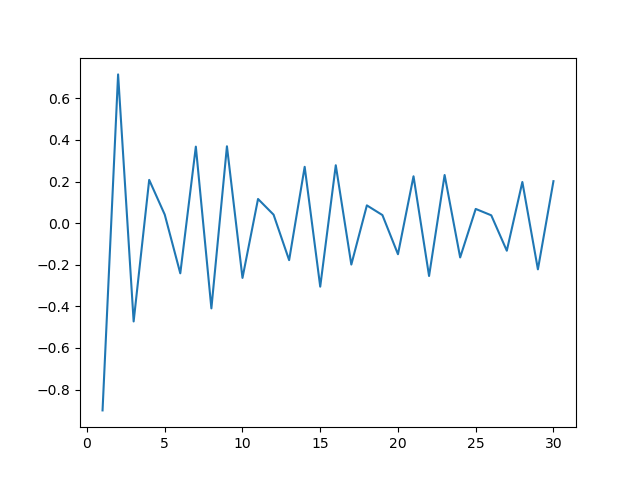

In [19]:
print(P.shape)

plt.figure()
plt.plot(np.arange(1,30+1),P)
plt.show()

In [20]:
C_const = (np.arange(1,n_max+1)+1)/(2*np.arange(1,n_max+1)+1)

In [21]:
C_const.shape

(30,)

In [23]:
#(C_const.reshape(-1,1)*R*pyshtools.legendre.PlSchmidt(n_max,cmu)[1:].reshape(-1,1)).shape

In [25]:
#np.sum(C_const.reshape(-1,1)*R*pyshtools.legendre.PlSchmidt(n_max,cmu)[1:].reshape(-1,1),axis=0).shape

In [27]:
#pyshtools.legendre.PlSchmidt(n_max,cmu)[1:].shape

In [28]:
C_Br = []

for cmu in np.ravel(c_angdist):
    C_Br.append(np.sum(C_const.reshape(-1,1)*R*pyshtools.legendre.PlSchmidt(n_max,cmu)[1:].reshape(-1,1),axis=0))

In [29]:
C_Br_shape = np.array(C_Br).reshape((c_angdist.shape[0],c_angdist.shape[1],-1))

In [30]:
C_Br_shape.shape

(1891, 1891, 487)

In [31]:
C_Br_zero = C_Br_shape.copy()
C_Br_zero[C_Br_zero<0.0] = 0.0

<IPython.core.display.Javascript object>


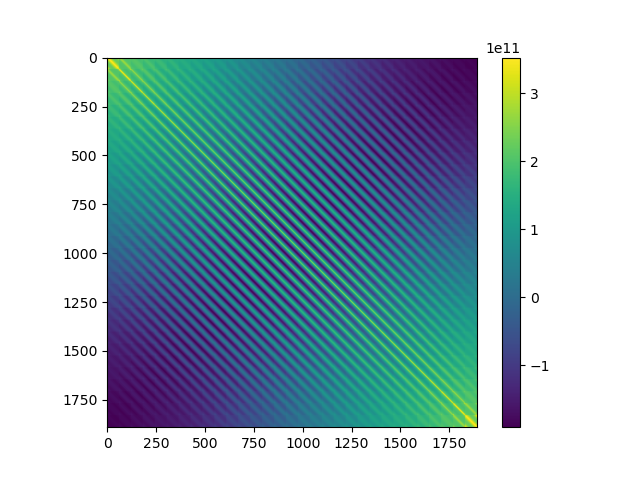

In [32]:
plt.figure()
plt.imshow(C_Br_shape[:,:,int(idx_close_to_var[-1])])
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


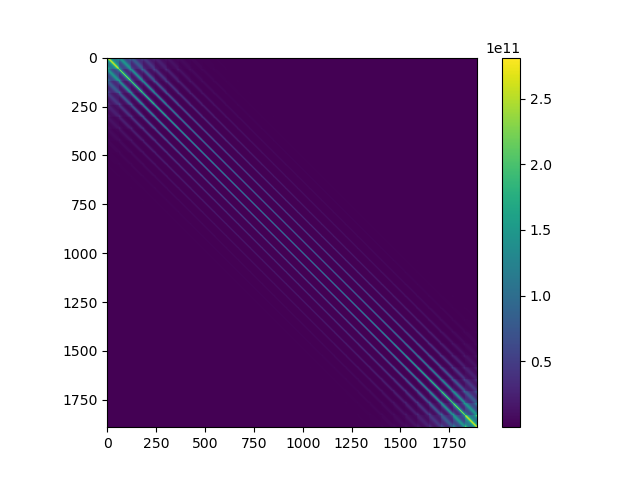

In [33]:
plt.figure()
plt.imshow(core.target_var - core.sv_lut)
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


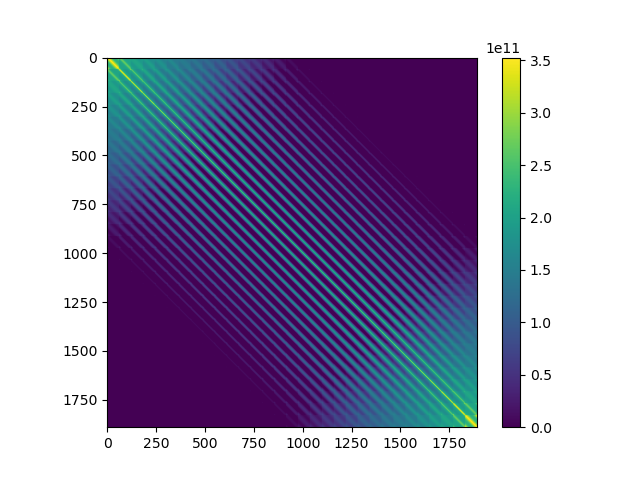

In [34]:
plt.figure()
plt.imshow(C_Br_zero[:,:,int(idx_close_to_var[-1])])
plt.colorbar()
plt.show()

In [35]:
print(core)


______current attributes______

a:                     6371.2
r_sat:                 6721.2
r_cmb:                 3480.0
rad:                   0.017453292519943295
mu0:                   1.2566370614359173e-06
comment:               Investigation into shape of ensemble of semi-variograms.
class_abs_path:        /home/mikotz/spherical_direct_sequential_simulation
N_SH:                  30
N_SH_secondary:        None
sim_type:              core
grid_zero:             (31,), Max/Min: 1.00 / -1.00
grid_w_shtools:        (31,), Max/Min: 0.10 / 0.01
grid_shape:            (2,), Max/Min: 61.00 / 31.00
grid_w:                (1891,), Max/Min: 0.10 / 0.01
grid_radial:           (1891,), Max/Min: 3480.00 / 3480.00
grid_theta:            (1891,), Max/Min: 175.63 / 4.37
grid_phi:              (1891,), Max/Min: 354.10 / 0.00
grid_N:                1891
grid_nmax:             30
r_grid:                3480.0
grid:                  (1891, 2)
sph_d:                 (1891, 1891)
lon:                

In [36]:
np.var(m_core_ens,axis=0).shape

(487,)

In [37]:
#ens_var = np.var(m_core_ens,axis=0)
ens_var = np.max(C_Br_shape,axis=0)

sv_spec = ens_var - C_Br_shape

In [38]:
sv_spec.shape

(1891, 1891, 487)

In [45]:
skip = 5

sph_d_skip = np.ravel(core.sph_d.reshape((core.N_grid,core.N_grid))[0::skip,0::skip])

i_sph_d_skip = np.argsort(sph_d_skip)

In [46]:
i_sph_d_skip.shape

(143641,)

<IPython.core.display.Javascript object>


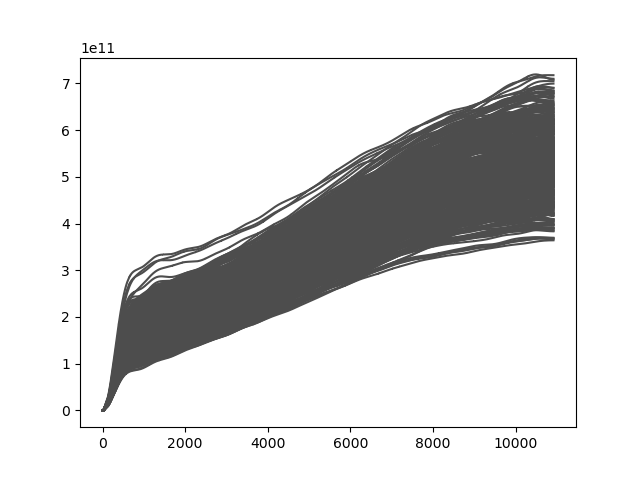

In [47]:
plt.figure()
for i in np.arange(0,sv_spec.shape[-1]):
    plt.plot(sph_d_skip[i_sph_d_skip], np.ravel(sv_spec[0::skip,0::skip,i])[i_sph_d_skip], color=(0.3,0.3,0.3))

plt.show()

<IPython.core.display.Javascript object>


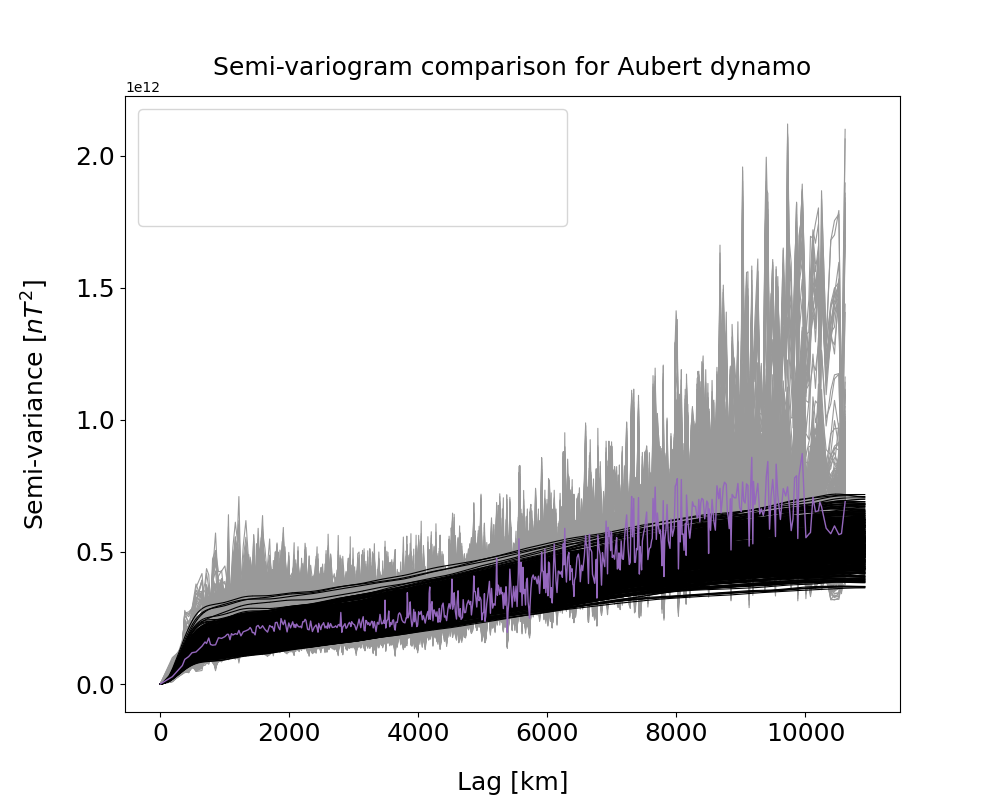

In [48]:
#%% PLOT SEMI-VARIOGRAM
plt.figure(figsize=(10,8)) 

for i in np.arange(0,sv_spec.shape[-1]):
    if i == 0:
        plt.plot(sph_d_skip[i_sph_d_skip], np.ravel(sv_spec[0::skip,0::skip,i])[i_sph_d_skip], 
                 linewidth = 0.8, color="k", label='SV from spectra', zorder=0.1)
    else:
        plt.plot(sph_d_skip[i_sph_d_skip], np.ravel(sv_spec[0::skip,0::skip,i])[i_sph_d_skip], 
                 linewidth = 0.8, color="k", zorder=0.2)

# Ensemble
for i in np.arange(0,m_core_ens.shape[1]):
    core.sv_m_DSS(m_core_ens.shape[0], 1, m_core_ens[:,[i]], core.sort_d, core.n_lags, core.max_cloud)
    if i == 0:
        plt.plot(core.lags, core.pics_m_DSS[:,0], color = (0.6,0.6,0.6), label='SV from field', linewidth = 0.8,zorder=0)
    elif i == idx_close_to_var[-1]:
        plt.plot(core.lags, core.pics_m_DSS[:,0], color = "C4", label='Most recent training image', linewidth = 1.0, zorder=0.2)
    else:
        plt.plot(core.lags, core.pics_m_DSS[:,0], color = (0.6,0.6,0.6), linewidth = 0.8,zorder=0) 

#plt.plot(core.lags,core.pics,'o', markersize=5,color = 'C4',label='Semi-variogram')

plt.ylabel('Semi-variance $[%s^2]$' % "nT",fontsize=18,labelpad=18)
plt.xlabel('Lag [km]',fontsize=18,labelpad=18)
plt.title("Semi-variogram comparison for Aubert dynamo",fontsize=18,y=1.02)
plt.legend(loc='best',fontsize=18)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.show()

In [43]:
np.max(core.sph_d)

10919.07508091069

In [44]:
np.min(np.ravel(sv_spec[0::skip,0::skip,:]))

0.0

In [50]:
ens_var_stat = np.var(m_core_ens,axis=0)

In [51]:
ens_var_stat.shape

(487,)

<IPython.core.display.Javascript object>


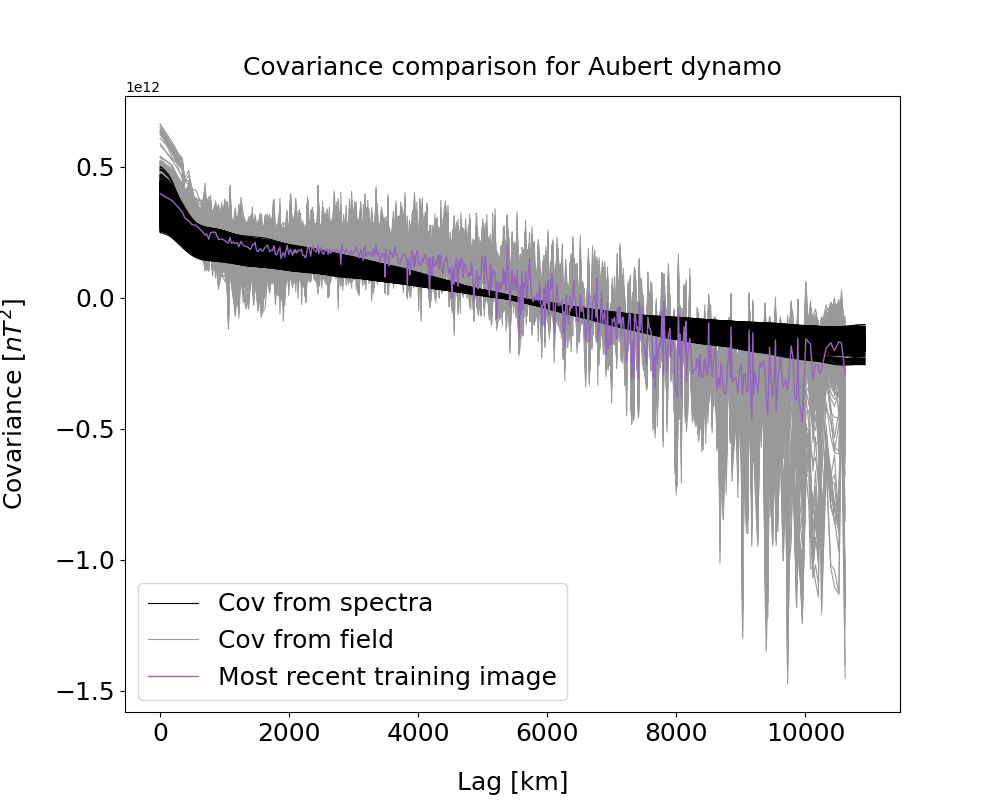

In [53]:
#%% PLOT COVARIANCE
plt.figure(figsize=(10,8)) 

for i in np.arange(0,sv_spec.shape[-1]):
    if i == 0:
        plt.plot(sph_d_skip[i_sph_d_skip], np.ravel(C_Br_shape[0::skip,0::skip,i])[i_sph_d_skip], 
                 linewidth = 0.8, color="k", label='Cov from spectra', zorder=0.1)
    else:
        plt.plot(sph_d_skip[i_sph_d_skip], np.ravel(C_Br_shape[0::skip,0::skip,i])[i_sph_d_skip], 
                 linewidth = 0.8, color="k", zorder=0.2)

# Ensemble
for i in np.arange(0,m_core_ens.shape[1]):
    core.sv_m_DSS(m_core_ens.shape[0], 1, m_core_ens[:,[i]], core.sort_d, core.n_lags, core.max_cloud)
    if i == 0:
        plt.plot(core.lags, ens_var_stat[i]-core.pics_m_DSS[:,0], color = (0.6,0.6,0.6), label='Cov from field', linewidth = 0.8,zorder=0)
    elif i == idx_close_to_var[-1]:
        plt.plot(core.lags, ens_var_stat[i]-core.pics_m_DSS[:,0], color = "C4", label='Most recent training image', linewidth = 1.0, zorder=0.2)
    else:
        plt.plot(core.lags, ens_var_stat[i]-core.pics_m_DSS[:,0], color = (0.6,0.6,0.6), linewidth = 0.8,zorder=0) 

#plt.plot(core.lags,core.pics,'o', markersize=5,color = 'C4',label='Semi-variogram')

plt.ylabel('Covariance $[%s^2]$' % "nT",fontsize=18,labelpad=18)
plt.xlabel('Lag [km]',fontsize=18,labelpad=18)
plt.title("Covariance comparison for Aubert dynamo",fontsize=18,y=1.02)
plt.legend(loc='best',fontsize=18)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.show()